In [0]:
import os
import cv2
import math
import numpy as np
import theano
import tensorflow as tf

from tensorflow import Graph
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1.keras.backend import set_session

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import Sequence



from keras.layers import ( Conv2D, Flatten, Lambda, Dense, concatenate,
                         Dropout, MaxPooling2D, Input, BatchNormalization)
from keras.models import Model


tf.compat.v1.disable_eager_execution()

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH = "/content/drive/My Drive/ProjectF"
%cd /content/drive/My Drive/ProjectF

/content/drive/My Drive/ProjectF


In [0]:
graph1 = Graph()

with graph1.as_default():
  session1 = Session()
  with session1.as_default():
      model = VGG16(weights='imagenet')

      sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
      model.compile(optimizer=sgd, loss='categorical_crossentropy')
      model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112,

In [0]:
from skimage.transform import resize

def get_hypercolumns(model, layer_indices, image):
    layers = []
    individual_hypercolumns = []
    hypercolumns = []
    for idx in layer_indices:
        layers.append(model.layers[idx].output)

    get_feature = K.function([model.layers[0].input], layers)
    features = get_feature(image)

    for feature_maps in features:
        feature_maps = feature_maps.reshape(feature_maps.shape[1], feature_maps.shape[2], feature_maps.shape[3])
        feature_maps = feature_maps.transpose((2, 0, 1))

        individual_hypercolumns.append(feature_maps)
        for map in feature_maps:
            hypercolumns.append(resize(map, (224, 224), mode='constant', preserve_range=True))

    return individual_hypercolumns, np.array(hypercolumns)




(1, 224, 224, 3)
(64, 224, 224)
(128, 112, 112)
(256, 56, 56)
(512, 28, 28)
(224, 224, 960)


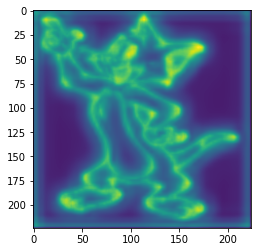

In [0]:
## Testing the hypercolumns 

im = cv2.resize(cv2.imread(os.path.join(PATH, 'playground/tom.png')), (224, 224)) / 255.0
im = im.reshape(1, im.shape[0], im.shape[1], im.shape[2])
print(im.shape)
layer_indices = [2, 5, 9, 13]

set_session(session1)
with graph1.as_default():
    individual_hypercolumns, hypercolumns = get_hypercolumns(model, layer_indices, im)

for hc in individual_hypercolumns:
    print (hc.shape)



avg = np.average(hypercolumns, axis=0)
plt.imshow(avg)

hypercolumns = hypercolumns.reshape(hypercolumns.shape[2], hypercolumns.shape[1], hypercolumns.shape[0])
print (hypercolumns.shape)

NUM_HC = hypercolumns.shape[-1]

In [0]:
## Function to convert YUV image to RGB. 
def yuv_to_rgb(yuv):
    ## Since we normalize the image it needs to be first brought back to original scale and converted to int

    yuv = (yuv * 255).astype(np.uint8)
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)


In [0]:
class Custom_Generator(Sequence):
    def __init__(self, file_paths, batch_size):
        self.file_paths = file_paths
        self.batch_size = batch_size

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, idx):
        batch = self.file_paths[idx * self.batch_size : (idx+1) * self.batch_size]

        X = []
        y = []
        layer_indices = [2, 5, 9, 13]
        for file in batch:
            yuv = cv2.resize(cv2.imread(file), (224, 224))
            yuv = cv2.cvtColor(yuv, cv2.COLOR_BGR2YUV) / 255.0
            uv = yuv[:, :, 1:3]

            gray = cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE), (224, 224)) / 255.0
            gray = np.repeat(gray[:, :, np.newaxis], 3, axis=2)
            gray = gray.reshape((1, gray.shape[0], gray.shape[1], gray.shape[2]))


            set_session(session1)
            with graph1.as_default():
              _, hc = get_hypercolumns(model, layer_indices, gray)
              hc = hc.reshape((hc.shape[2], hc.shape[1], hc.shape[0]))

            X.append(hc)
            y.append(uv)

        return np.array(X), np.array(y)


In [0]:
## Getting the filepaths of all the images of the lfw dataset. Takes long for this to run
path = os.path.join(PATH, 'lfw')
file_paths = []
num_images = 200

for folder in os.listdir(path):
    ## Breaking after loading required number of images
    if len(file_paths) > num_images:
        break
    joint_path = os.path.join(path, folder)
    for file_name in os.listdir(joint_path):
        file_paths.append(os.path.join(joint_path, file_name))



In [0]:
graph2 = Graph()

with graph2.as_default():
    session2 = Session()
    with session2.as_default():
        input = Input(shape=(224, 224, NUM_HC))

        conv1 = Conv2D(128, 1, padding='same', activation='relu', input_shape=(224, 224, NUM_HC))(input)
        batch_norm1 = BatchNormalization(axis=-1)(conv1)
        conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(batch_norm1)
        batch_norm2 = BatchNormalization(axis=-1)(conv2)
        output = Conv2D(2, (3, 3), padding='same', activation='sigmoid')(batch_norm2)

        cnn_model = Model(inputs=input, outputs=output)
        opt = Adam(lr=0.001)

        cnn_model.compile(optimizer=opt, loss='mean_squared_error')
        cnn_model._make_predict_function()
        cnn_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 960)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 128)     123008    
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 128)     512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 2)       1154      
Total params: 198,722
Trainable params: 198,338
Non-trainable params: 384
___________________________________________________

In [0]:
## Training 

from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(file_paths, test_size=0.2, random_state=1)

print ('Training size = ', len(train_set))
print ('Validation size = ', len(val_set))

batch_size = 2
epochs = 10

train_generator = Custom_Generator(train_set, batch_size)
val_generator = Custom_Generator(val_set, batch_size)

set_session(session2)
with graph2.as_default():
    cnn_model.fit_generator(generator=train_generator,
                  steps_per_epoch=(len(train_set) // batch_size),
                  epochs=epochs,
                  verbose=1,
                  validation_data=val_generator,
                  validation_steps=(len(val_set) // batch_size))



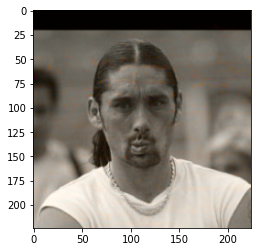

In [0]:
## Testing on a single image

gray = cv2.resize(cv2.imread(train_set[0], cv2.IMREAD_GRAYSCALE), (224, 224)) / 255.0
gray_3d = gray.reshape((224, 224, 1))
test_im = np.repeat(gray_3d[:, :, np.newaxis], 3, axis=2)
test_im = test_im.reshape((1, test_im.shape[0], test_im.shape[1], test_im.shape[2]))

set_session(session1)
with graph1.as_default():

    _, hc = get_hypercolumns(model, [2, 5, 9, 13], test_im)
    hc = hc.reshape((1, hc.shape[2], hc.shape[1], hc.shape[0]))



set_session(session2)
with graph2.as_default():
    pred = cnn_model.predict(hc)

    gray = gray.reshape((224, 224, 1))
    pred = pred.reshape((224, 224, 2))
    pred_yuv = np.concatenate((gray, pred), axis=2)

    plt.imshow(yuv_to_rgb(pred_yuv))